# 2. Data Simulation

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import json

from pathlib import Path

In [16]:
MAIN_DIR = Path.cwd().parent
DATA_DIR = MAIN_DIR / 'data'
EXP_DIR = MAIN_DIR / 'experiments'
NOTEBOOKS_DIR = MAIN_DIR / 'notebooks'
RESULTS_DIR = MAIN_DIR / 'results'
SRC_DIR = MAIN_DIR / 'src'

FIGURES_DIR = RESULTS_DIR / 'figures'

In [31]:
sys.path.append(str(SRC_DIR))

import simulation
importlib.reload(simulation)

from simulation import (
    LotkaVolterraSimulator,
    RosenzweigMacArthurSimulator
)

### 2.1 Simulating Data with Lotke-Volterra

$$ \frac{dA}{dt} = rA - \alpha AR $$
$$ \frac{dR}{dt} = \beta AR - dR $$

Parameters:
- $A$ = Algae population (prey)
- $R$ = Rotifer population (predator)
- $r$ = Growth rate of algae
- $\alpha$ = Predation rate (how well rotifers consume algae)
- $\beta$ = Reproduction efficiency of rotifers
- $d$ = Rotifer mortality rate

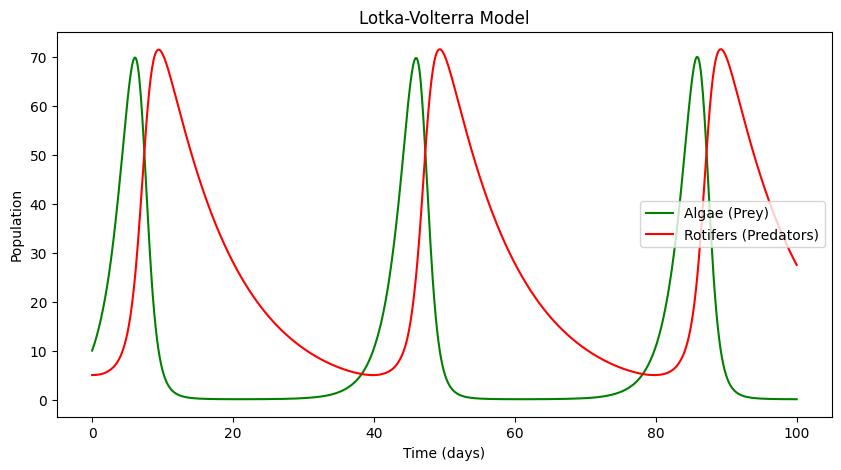

In [18]:
params = {"r": 0.5, "alpha": 0.02, "beta": 0.01, "d": 0.1}
initial_conditions = (10, 5)  # Starting algae & rotifer populations
t_range = (0, 100, 1000)  # Simulate from t=0 to t=100 with 1000 time points

lv_sim = LotkaVolterraSimulator(params, initial_conditions, t_range)
solution = lv_sim.simulate()
lv_sim.plot_results(solution, title="Lotka-Volterra Model")

### 2.2 Simulating Data with Rosenzweig-MacArthur

$$ \frac{dA}{dt} = rA \left(1 - \frac{A}{K} \right) - \frac{\alpha AR}{A + H} $$
$$ \frac{dR}{dt} = \beta \frac{\alpha AR}{A + H} - dR $$

Parameters:
- $A$ = Algae population (prey)
- $R$ = Rotifer population (predator)
- $r$ = Growth rate of algae
- $\alpha$ = Predation rate (how well rotifers consume algae)
- $\beta$ = Reproduction efficiency of rotifers
- $d$ = Rotifer mortality rate
- $K$ = Carrying capacity of algae
- $H$ = Half-saturation constant (prey density at which predation rate is half of $\alpha$)

$\Rightarrow$ Logistic growth of algae and predator saturation

In [49]:
params = {
    "r": 0.1,
    "K": 1000,
    "alpha": 10,
    "H": 10,
    "beta": 0.01,
    "d": 0.05
}
initial_conditions = (500, 100)  # Starting populations for algae and rotifers
t_range = (0, 100, 1000)  # Simulate from t=0 to t=100 with 1000 time points

rm_sim = RosenzweigMacArthurSimulator(params, initial_conditions, t_range)
solution = rm_sim.simulate()
rm_sim.plot_results(solution, title="Rosenzweig-MacArthur Model")

KeyboardInterrupt: 